In [1]:
from pyqae.images.pipelines import WrappedChannelTransform, visualize_pipeline
from pyqae.images.pipelines import flatten_transform, add_position_transform, add_normpos_transform
from pyqae.images.pipelines import add_threshold_transform,normalize_transform,add_filter_transform

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from skimage.util.montage import montage2d
import matplotlib.pyplot as plt

In [4]:
with np.load('/Users/mader/Dropbox/4Quant/Projects/AnatomySegmentation/age_vert_training.npz') as ftd:
    train_img_f = np.expand_dims(ftd['raw_images'],1)
    lab_names = ftd['semantic_names'].astype(np.str) # make into unicode (from py27 byte)
    lab_img = np.stack([ftd['semantic_label']==i for i,_ in enumerate(lab_names) if i>0],1).astype(np.float32)
    im_cnt, im_ch, im_xdim, im_ydim = train_img_f.shape
    print(train_img_f.shape, lab_img.shape, lab_img.dtype, lab_names)

(179, 1, 512, 512) (179, 3, 512, 512) float32 ['nothing' 'bone' 'vert' 'pelvis']


In [5]:
train_ids=np.random.permutation(range(len(train_img_f)))

c_idx = np.random.choice(train_ids, 20)
x_train = train_img_f[c_idx][:,:,::2,::2]

y_train = lab_img[c_idx,:,::2,::2]
print(x_train.shape,x_train.min(),x_train.max())
print(y_train.shape)


(20, 1, 256, 256) -1024.0 3070.0
(20, 3, 256, 256)


In [6]:
bone_seg_pipe = Pipeline([
        ('filter_big',add_filter_transform(False,'th',filter_width=4)),
        ('filter_medium',add_filter_transform(False,'th',filter_width=2,image_channel=1)),
        ('filter_fine',add_filter_transform(False,'th',filter_width=1,image_channel=2)),
        ('add_thresh',add_threshold_transform(300,2000,0,False,'th')),
        ('Pos',add_normpos_transform(False,'th')),
        ('Normalize',normalize_transform()),
        ('RFRegress',WrappedChannelTransform(RandomForestRegressor(),'th',use_predict=True, flatten_y=True, class_predict=False))
    ])

In [7]:
%%time
bone_seg_pipe.fit(x_train,y_train)

CPU times: user 1min 27s, sys: 760 ms, total: 1min 28s
Wall time: 1min 29s


Pipeline(steps=[('filter_big', <pyqae.images.pipelines.ChannelPipeTransform object at 0x104914860>), ('filter_medium', <pyqae.images.pipelines.ChannelPipeTransform object at 0x104914978>), ('filter_fine', <pyqae.images.pipelines.ChannelPipeTransform object at 0x1049147b8>), ('add_thresh', <pyqae.images.pipel...x104914748>), ('RFRegress', <pyqae.images.pipelines.WrappedChannelTransform object at 0x1172430f0>)])

filter_big - (1, 2, 256, 256)
filter_medium - (1, 3, 256, 256)
filter_fine - (1, 4, 256, 256)
add_thresh - (1, 5, 256, 256)
Pos - (1, 7, 256, 256)
Normalize - (1, 7, 256, 256)
RFRegress - (1, 3, 256, 256)
filter_big - (1, 2, 256, 256)
filter_medium - (1, 3, 256, 256)
filter_fine - (1, 4, 256, 256)
add_thresh - (1, 5, 256, 256)
Pos - (1, 7, 256, 256)
Normalize - (1, 7, 256, 256)
RFRegress - (1, 3, 256, 256)


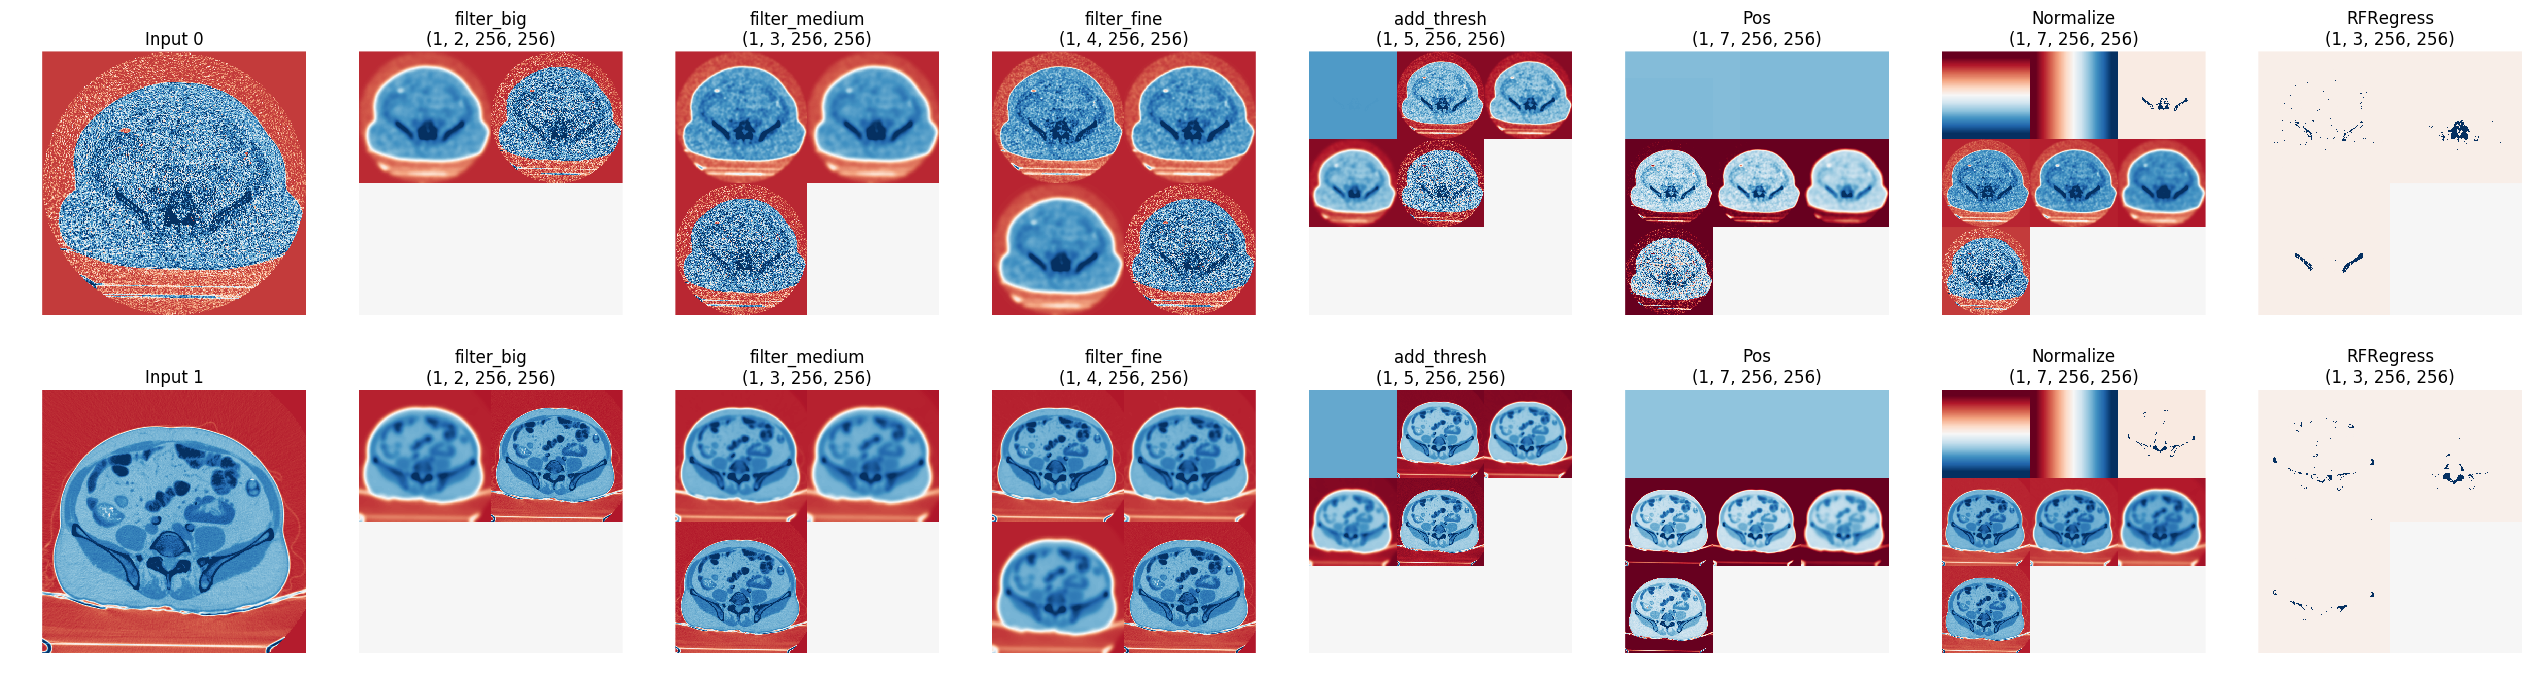

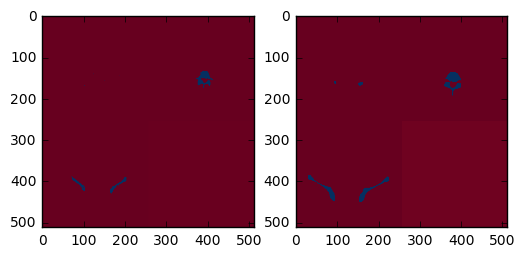

In [8]:
%matplotlib inline

n_idx=np.random.choice(len(x_train),2)
_=visualize_pipeline(bone_seg_pipe,x_train[n_idx],True)

fig, m_ax=plt.subplots(1,len(n_idx))
for idx,c_ax in zip(n_idx,m_ax):
    c_ax.imshow(montage2d(y_train[idx]),cmap='RdBu')

filter_big - (1, 2, 256, 256)
filter_medium - (1, 3, 256, 256)
filter_fine - (1, 4, 256, 256)
add_thresh - (1, 5, 256, 256)
PCA_Image - (1, 4, 256, 256)
Pos - (1, 6, 256, 256)
Normalize - (1, 6, 256, 256)
RFRegress - (1, 3, 256, 256)
filter_big - (1, 2, 256, 256)
filter_medium - (1, 3, 256, 256)
filter_fine - (1, 4, 256, 256)
add_thresh - (1, 5, 256, 256)
PCA_Image - (1, 4, 256, 256)
Pos - (1, 6, 256, 256)
Normalize - (1, 6, 256, 256)
RFRegress - (1, 3, 256, 256)


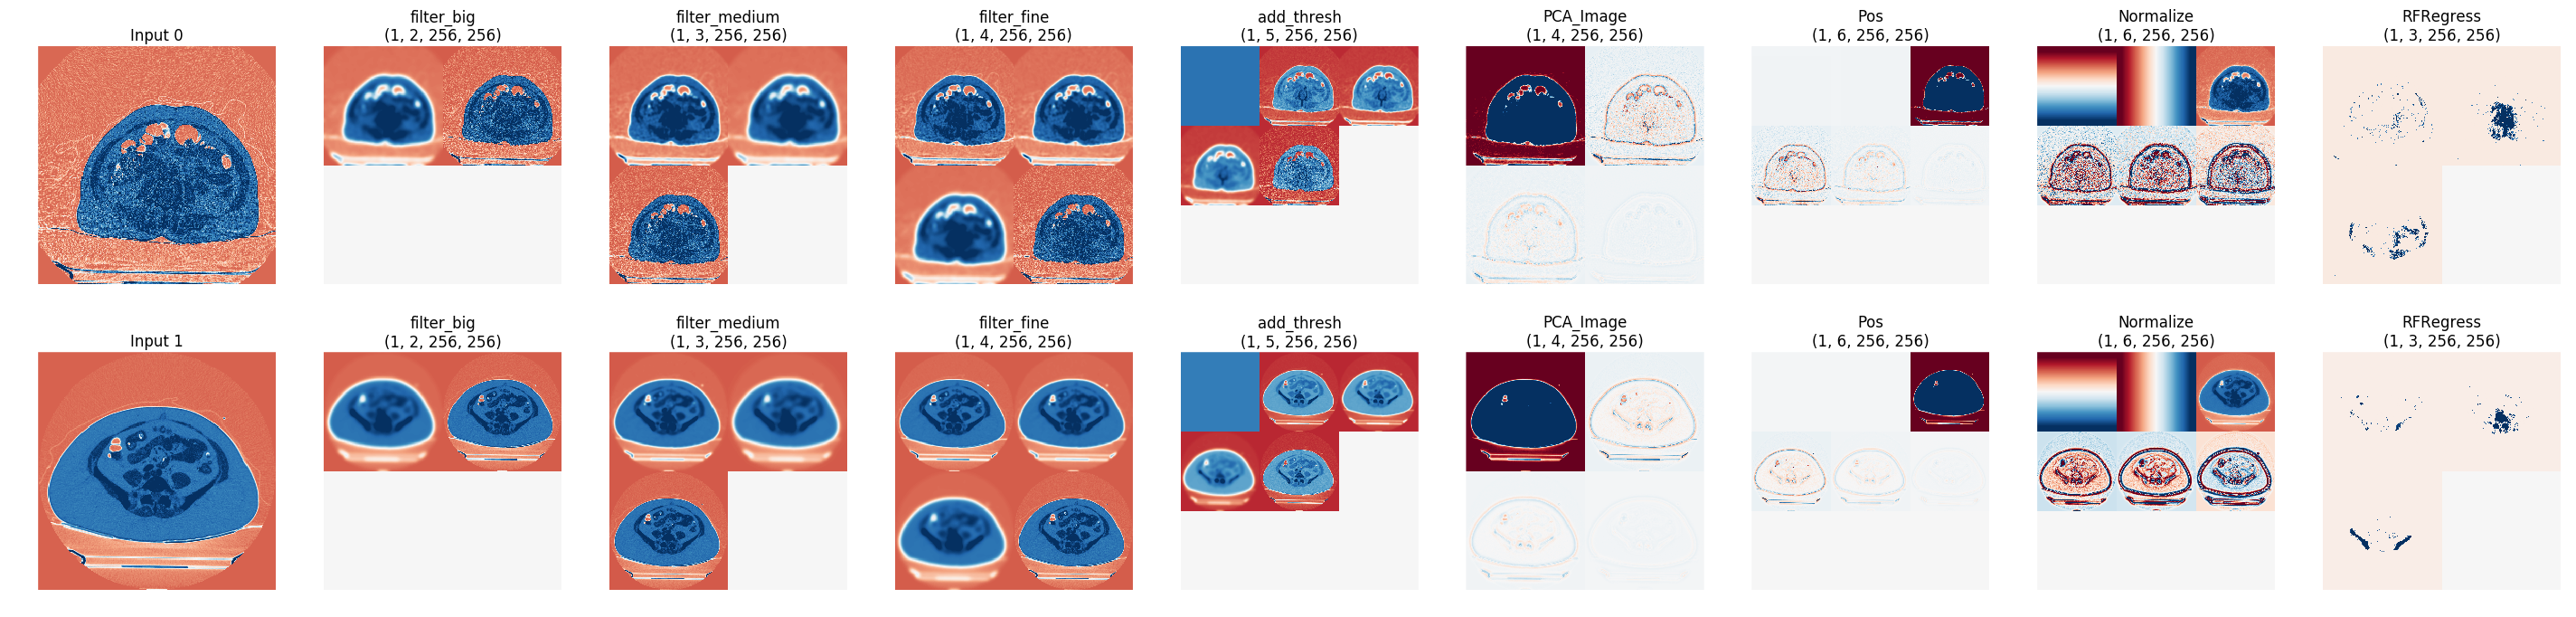

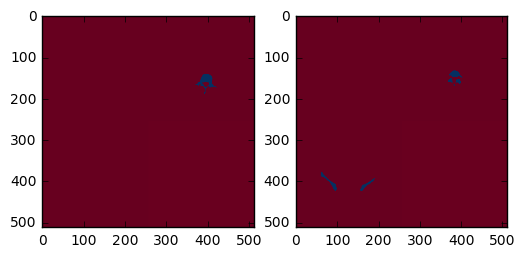

In [ ]:
bone_seg_pipe = Pipeline([
        ('filter_big',add_filter_transform(False,'th',filter_width=4)),
        ('filter_medium',add_filter_transform(False,'th',filter_width=2,image_channel=1)),
        ('filter_fine',add_filter_transform(False,'th',filter_width=1,image_channel=2)),
        ('add_thresh',add_threshold_transform(300,2000,0,False,'th')),
        ('PCA_Image',WrappedChannelTransform(PCA(n_components=4),'th')),
        ('Pos',add_normpos_transform(False,'th')),
        ('Normalize',normalize_transform()),
        ('RFRegress',WrappedChannelTransform(RandomForestRegressor(),'th',use_predict=True, flatten_y=True, class_predict=False))
    ])
bone_seg_pipe.fit(x_train,y_train)
%matplotlib inline

n_idx=np.random.choice(len(x_train),2)
_=visualize_pipeline(bone_seg_pipe,x_train[n_idx],True)

fig, m_ax=plt.subplots(1,len(n_idx))
for idx,c_ax in zip(n_idx,m_ax):
    c_ax.imshow(montage2d(y_train[idx]),cmap='RdBu')

In [ ]:
kbone_seg_pipe = Pipeline([
        ('filter_big',add_filter_transform(False,'th',filter_width=4)),
        ('filter_medium',add_filter_transform(False,'th',filter_width=2,image_channel=1)),
        ('filter_fine',add_filter_transform(False,'th',filter_width=1,image_channel=2)),
        ('add_thresh',add_threshold_transform(300,2000,0,False,'th')),
        ('Normalize',normalize_transform()),
        ('PCA_Collapse',WrappedChannelTransform(PCA(n_components=4),'th')),
        ('KMeans_Intensity',WrappedChannelTransform(KMeans(9),'th',use_predict=False)),
        ('Pos',add_normpos_transform(False,'th')),
        ('Normalize_Position',normalize_transform()),
        ('PCA_Image',WrappedChannelTransform(PCA(n_components=6),'th')),
        ('kregress',WrappedChannelTransform(RandomForestRegressor(),'th',use_predict=True, flatten_y=True, class_predict=False))
    ])
kbone_seg_pipe.fit(x_train, y_train)

In [ ]:
%matplotlib inline

n_idx=np.random.choice(len(x_train),2)
_=visualize_pipeline(kbone_seg_pipe,x_train[n_idx],True)

fig, m_ax=plt.subplots(1,len(n_idx))
for idx,c_ax in zip(n_idx,m_ax):
    c_ax.imshow(montage2d(y_train[idx]),cmap='RdBu')

In [ ]:
big_kbone_seg_pipe = Pipeline([
        ('KMeans_Intensity',WrappedChannelTransform(KMeans(9),'th',use_predict=False)),
        ('Normalize',normalize_transform()),
        ('Pos',add_normpos_transform(False,'th')),
        ('KMeans_All',WrappedChannelTransform(KMeans(25),'th',use_predict=False)),
        ('rfregress',WrappedChannelTransform(KNeighborsRegressor(3),'th',use_predict=True, flatten_y=True, class_predict=False))
    ])
big_kbone_seg_pipe.fit(x_train, y_train)

In [ ]:
%matplotlib inline

n_idx=np.random.choice(len(x_train),2)
_=visualize_pipeline(big_kbone_seg_pipe,x_train[n_idx],True)

fig, m_ax=plt.subplots(1,len(n_idx))
for idx,c_ax in zip(n_idx,m_ax):
    c_ax.imshow(montage2d(y_train[idx]),cmap='RdBu')

In [ ]:
from skimage.segmentation import slic

In [ ]:
slic(np.ones((3,3,9)))

In [ ]:
np.ones((3,3,9)).transpose().shape